# Predicitive maintanance model

Made by: Joey Einerhand, Cédric Cortenraede, Lennox Narinx, Giuseppe Collura

## Get file
All files from the data directory will be loaded, _*this can take some time_\
based on the loaded data a dataframe will be created

In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Update "data_dir" location if necessary
data_dir = "data"
files = os.listdir(data_dir)
files = [file for file in files if file != "documentation.txt" and file != "description.txt" and file != "profile.txt" and file.endswith(".txt")]

In [3]:
df = pd.DataFrame()

# Load the sensor data
# Takes the mean of each row to illuminate different frequencies
for i in range(len(files)):
    df[files[i].strip(".txt")] = pd.read_csv(os.path.join(data_dir, files[i]), sep="\t", header=None, names=[files[i]]).mean(axis=1).to_numpy()

# Load the profiles
profiles = ["Cooler condition", "Valve condition", "Internal pump leakage", "Hydraulic accumulator", "Stable flag"]
for i in range(len(profiles)):
    df[profiles[i]] = pd.read_csv(os.path.join(data_dir,'profile.txt'), sep="\t", header=None)[i].to_numpy()
    
df

,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,Stable flag
0,28.866,1.383,2409.6,8.036,10.373,151.19,125.10,2.211,0.000,9.722,...,36.152,41.250,38.594,33.555,0.543,3,100,0,130,1
1,23.588,1.164,2397.8,7.890,10.391,150.86,125.04,2.219,0.000,9.623,...,37.477,42.105,39.250,35.121,0.534,3,100,0,130,1
2,21.519,1.103,2383.8,7.952,10.356,150.62,124.88,2.266,0.000,9.521,...,38.621,43.035,40.043,36.121,0.534,3,100,0,130,1
3,20.403,1.091,2372.0,7.773,10.261,150.28,124.59,2.273,0.000,9.420,...,39.461,43.988,40.922,36.988,0.542,3,100,0,130,1
4,20.016,1.106,2369.6,7.825,10.216,150.19,124.51,2.297,0.000,9.333,...,40.391,44.871,41.758,37.754,0.537,3,100,0,130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.382,2.142,2415.6,7.874,10.171,151.86,125.73,2.273,10.207,9.979,...,35.414,40.922,38.187,30.379,0.527,100,100,0,90,0
2201,46.729,2.134,2413.6,7.787,10.174,151.78,125.44,2.406,10.193,9.953,...,35.398,40.891,38.195,30.375,0.544,100,100,0,90,0
2202,46.502,2.144,2413.6,7.685,10.171,151.83,125.94,2.250,10.246,9.998,...,35.437,40.898,38.160,30.379,0.517,100,100,0,90,0
2203,46.570,2.148,2415.6,7.793,10.189,151.78,125.91,2.281,10.189,9.953,...,35.441,40.898,38.176,30.375,0.528,100,100,0,90,0


In [4]:
# Turn profile categories into labels.
label_encoder_cooler_condition = preprocessing.LabelEncoder()
label_encoder_valve_condition = preprocessing.LabelEncoder()
label_encoder_internal_pump_leakage = preprocessing.LabelEncoder()
label_encoder_hydraulic_accumulator = preprocessing.LabelEncoder()

df["Cooler condition"] = label_encoder_cooler_condition.fit_transform(df["Cooler condition"])
df["Valve condition"] = label_encoder_valve_condition.fit_transform(df["Valve condition"])
df["Internal pump leakage"] = label_encoder_valve_condition.fit_transform(df["Internal pump leakage"])
df["Hydraulic accumulator"] = label_encoder_valve_condition.fit_transform(df["Hydraulic accumulator"])

df

,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,Stable flag
0,28.866,1.383,2409.6,8.036,10.373,151.19,125.10,2.211,0.000,9.722,...,36.152,41.250,38.594,33.555,0.543,0,3,0,3,1
1,23.588,1.164,2397.8,7.890,10.391,150.86,125.04,2.219,0.000,9.623,...,37.477,42.105,39.250,35.121,0.534,0,3,0,3,1
2,21.519,1.103,2383.8,7.952,10.356,150.62,124.88,2.266,0.000,9.521,...,38.621,43.035,40.043,36.121,0.534,0,3,0,3,1
3,20.403,1.091,2372.0,7.773,10.261,150.28,124.59,2.273,0.000,9.420,...,39.461,43.988,40.922,36.988,0.542,0,3,0,3,1
4,20.016,1.106,2369.6,7.825,10.216,150.19,124.51,2.297,0.000,9.333,...,40.391,44.871,41.758,37.754,0.537,0,3,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,46.382,2.142,2415.6,7.874,10.171,151.86,125.73,2.273,10.207,9.979,...,35.414,40.922,38.187,30.379,0.527,2,3,0,0,0
2201,46.729,2.134,2413.6,7.787,10.174,151.78,125.44,2.406,10.193,9.953,...,35.398,40.891,38.195,30.375,0.544,2,3,0,0,0
2202,46.502,2.144,2413.6,7.685,10.171,151.83,125.94,2.250,10.246,9.998,...,35.437,40.898,38.160,30.379,0.517,2,3,0,0,0
2203,46.570,2.148,2415.6,7.793,10.189,151.78,125.91,2.281,10.189,9.953,...,35.441,40.898,38.176,30.375,0.528,2,3,0,0,0


In [5]:
# Add timestamps to data.
df["Time"] = df.apply(
    lambda row: row.name * 60, axis=1
)

col = df.pop("Time")
df.insert(0, col.name, col)

df

,Time,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,...,TS1,TS2,TS3,TS4,VS1,Cooler condition,Valve condition,Internal pump leakage,Hydraulic accumulator,Stable flag
0,0,28.866,1.383,2409.6,8.036,10.373,151.19,125.10,2.211,0.000,...,36.152,41.250,38.594,33.555,0.543,0,3,0,3,1
1,60,23.588,1.164,2397.8,7.890,10.391,150.86,125.04,2.219,0.000,...,37.477,42.105,39.250,35.121,0.534,0,3,0,3,1
2,120,21.519,1.103,2383.8,7.952,10.356,150.62,124.88,2.266,0.000,...,38.621,43.035,40.043,36.121,0.534,0,3,0,3,1
3,180,20.403,1.091,2372.0,7.773,10.261,150.28,124.59,2.273,0.000,...,39.461,43.988,40.922,36.988,0.542,0,3,0,3,1
4,240,20.016,1.106,2369.6,7.825,10.216,150.19,124.51,2.297,0.000,...,40.391,44.871,41.758,37.754,0.537,0,3,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,132000,46.382,2.142,2415.6,7.874,10.171,151.86,125.73,2.273,10.207,...,35.414,40.922,38.187,30.379,0.527,2,3,0,0,0
2201,132060,46.729,2.134,2413.6,7.787,10.174,151.78,125.44,2.406,10.193,...,35.398,40.891,38.195,30.375,0.544,2,3,0,0,0
2202,132120,46.502,2.144,2413.6,7.685,10.171,151.83,125.94,2.250,10.246,...,35.437,40.898,38.160,30.379,0.517,2,3,0,0,0
2203,132180,46.570,2.148,2415.6,7.793,10.189,151.78,125.91,2.281,10.189,...,35.441,40.898,38.176,30.375,0.528,2,3,0,0,0


## Analyse data
- The analysis looks at the correlation of the different columns in comparison to each other\
- This gives a filter to use later\
- The filter will be used to determine the columns impacting for the result

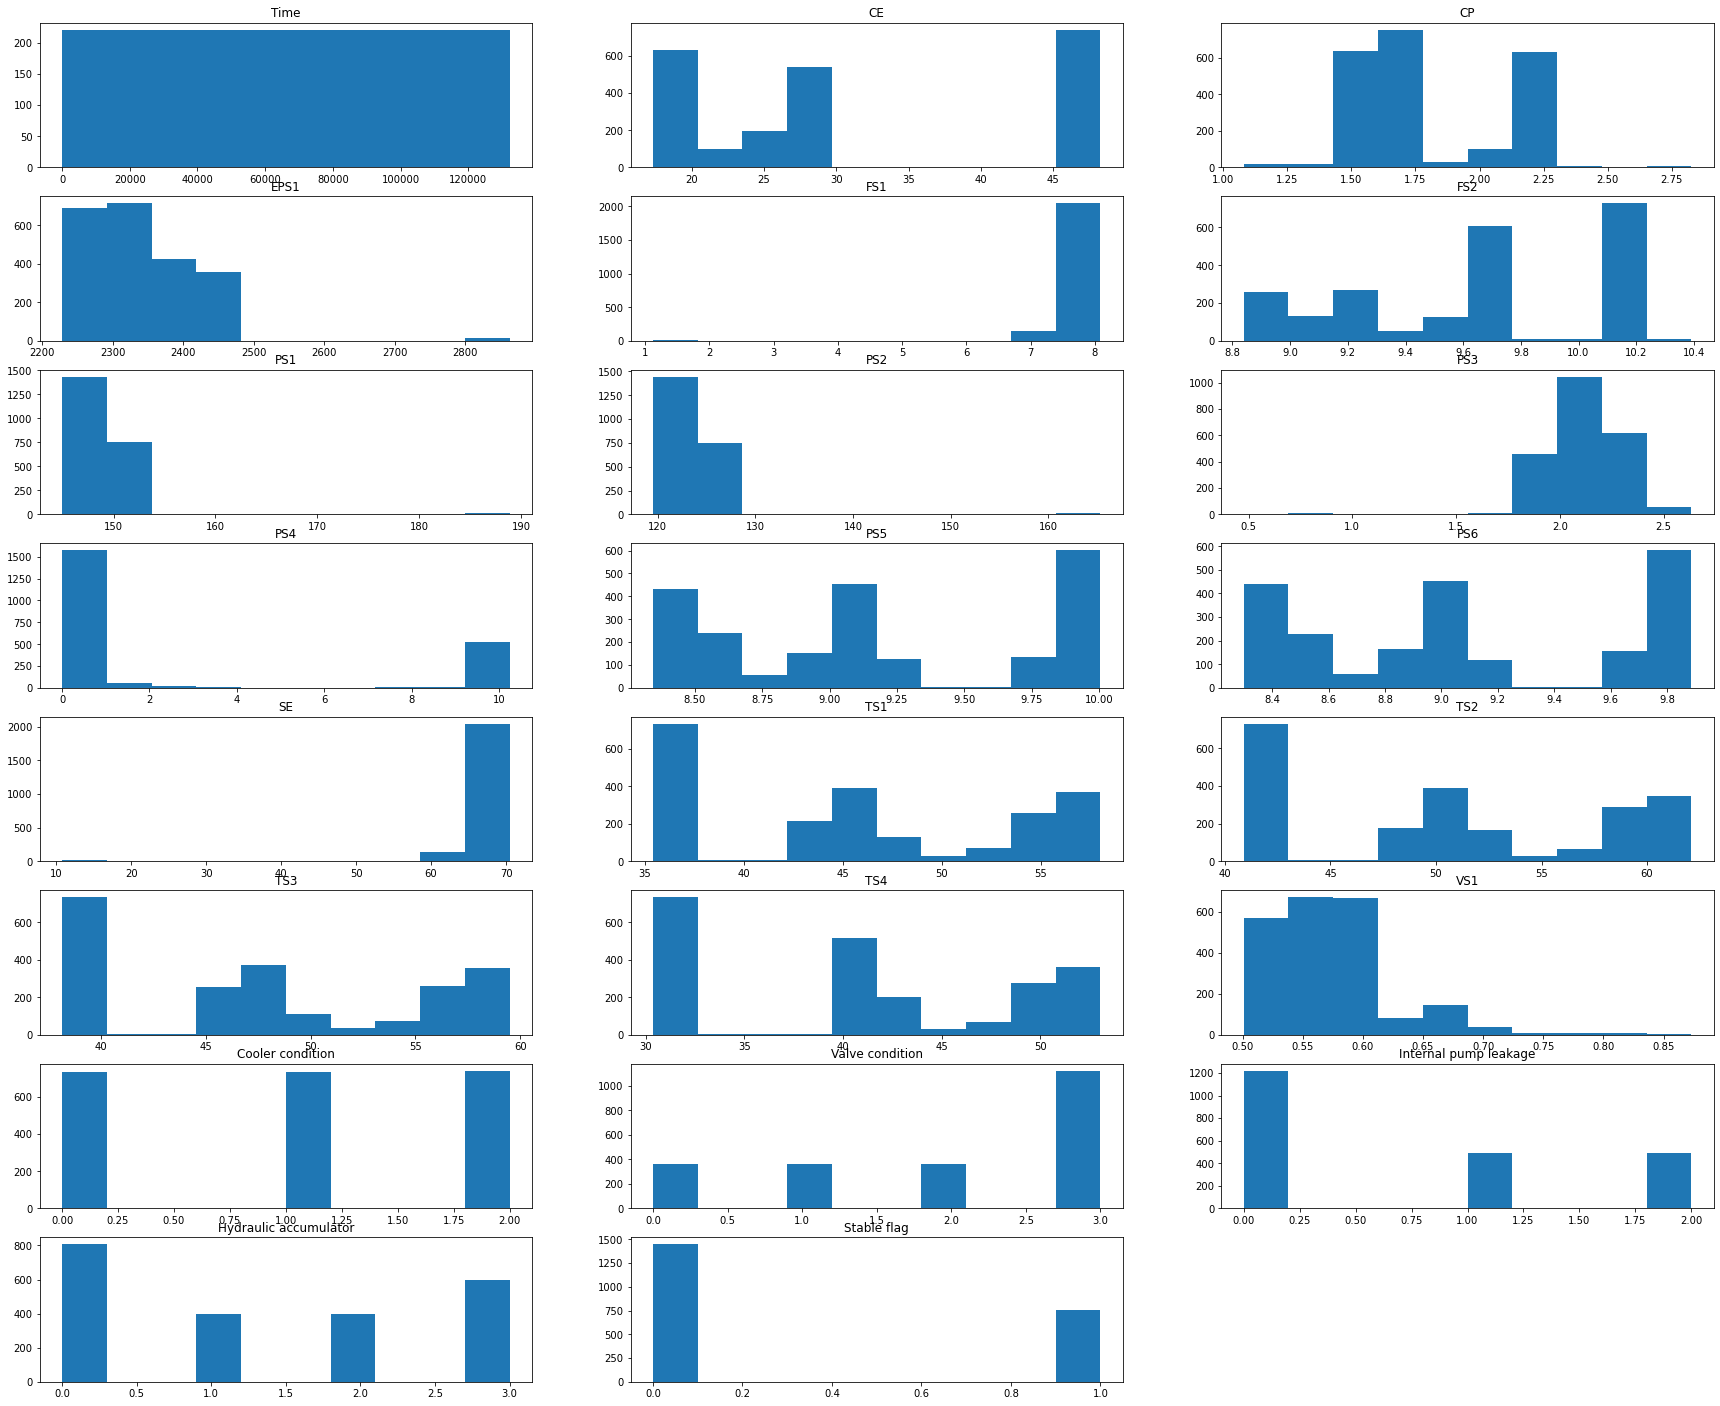

In [6]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    plt.hist(data)
    
    i += 1

plt.show()

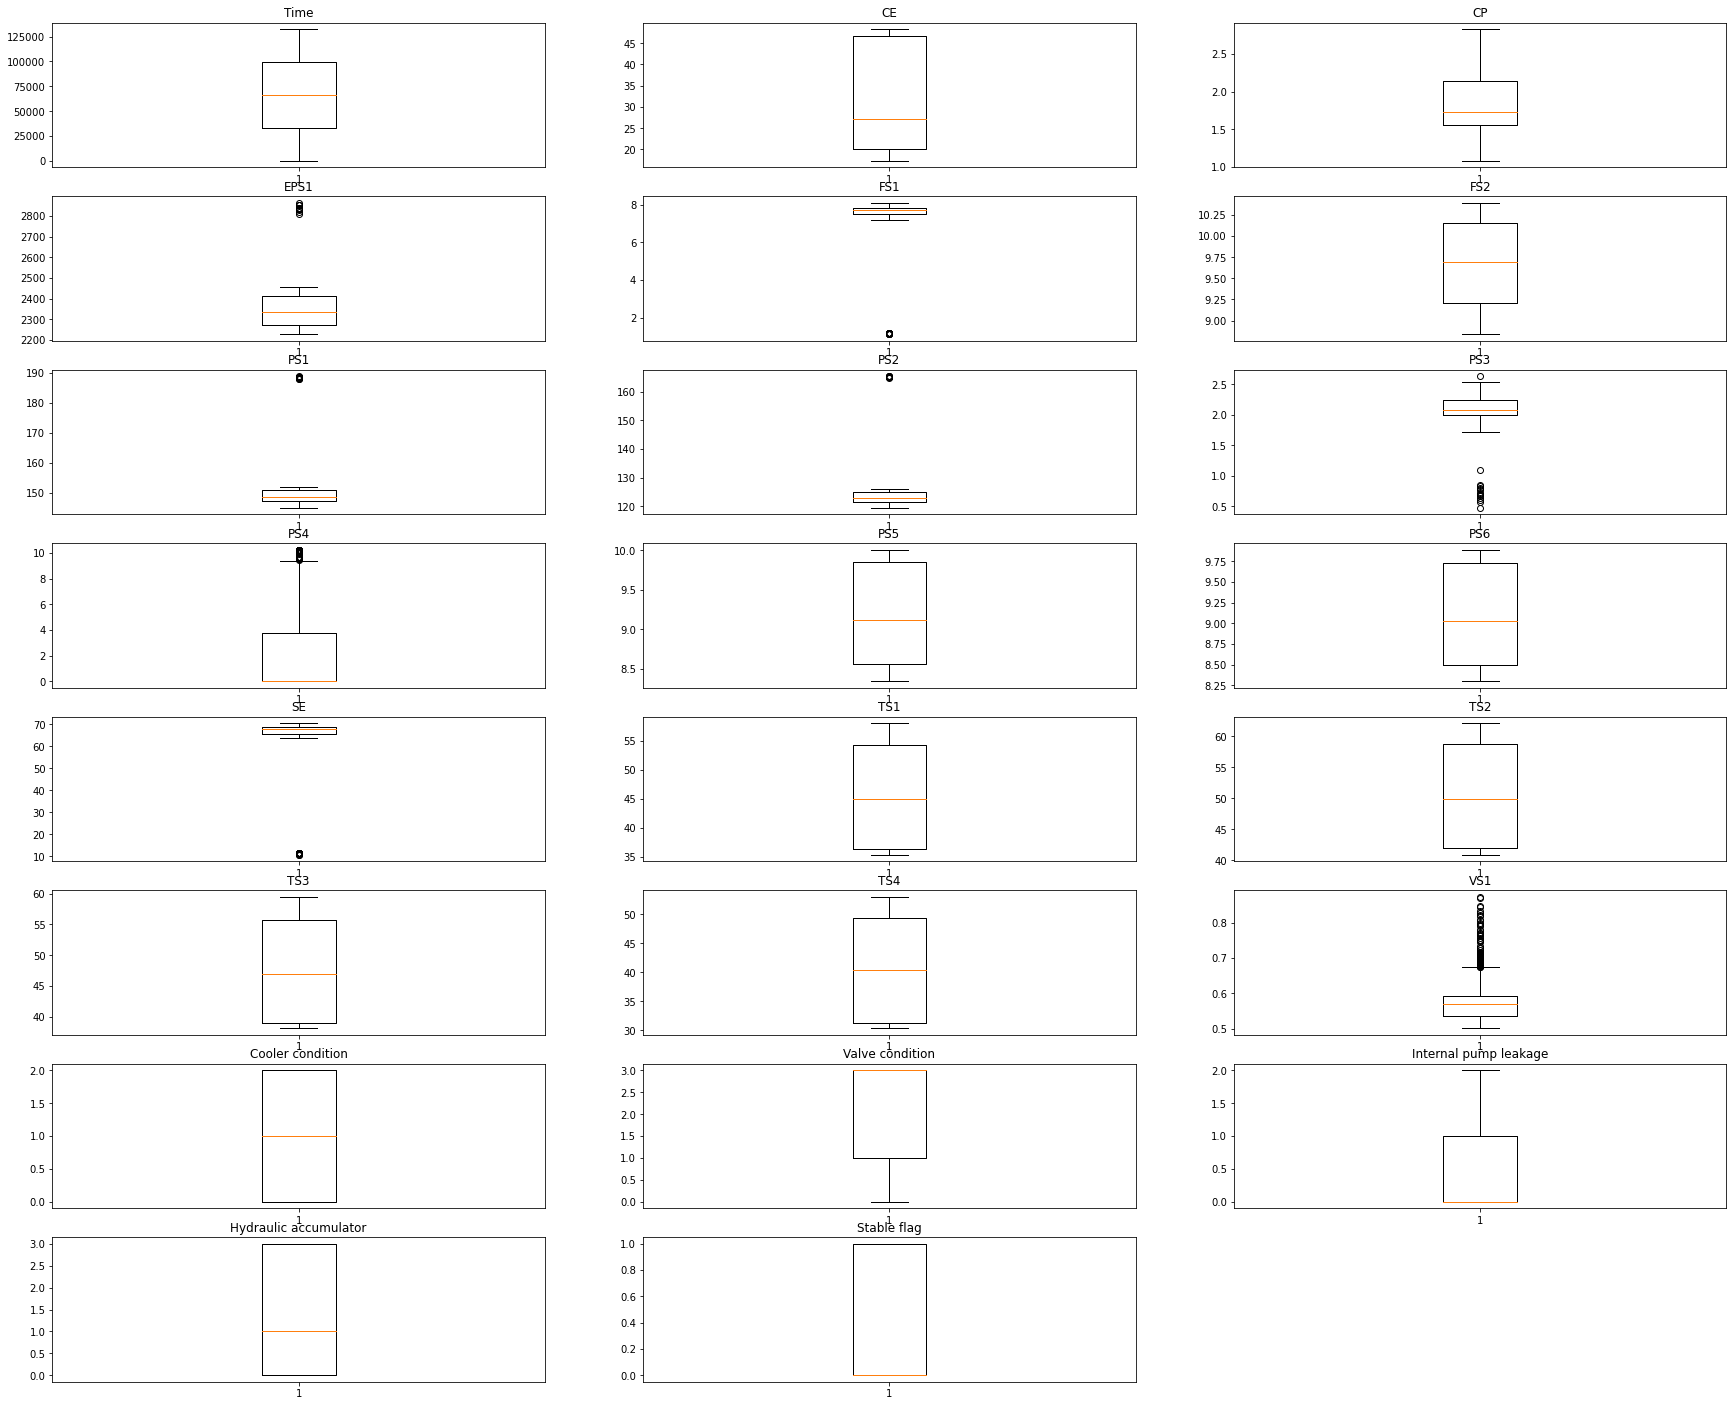

In [7]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    plt.boxplot(data)
    
    i += 1

plt.show()

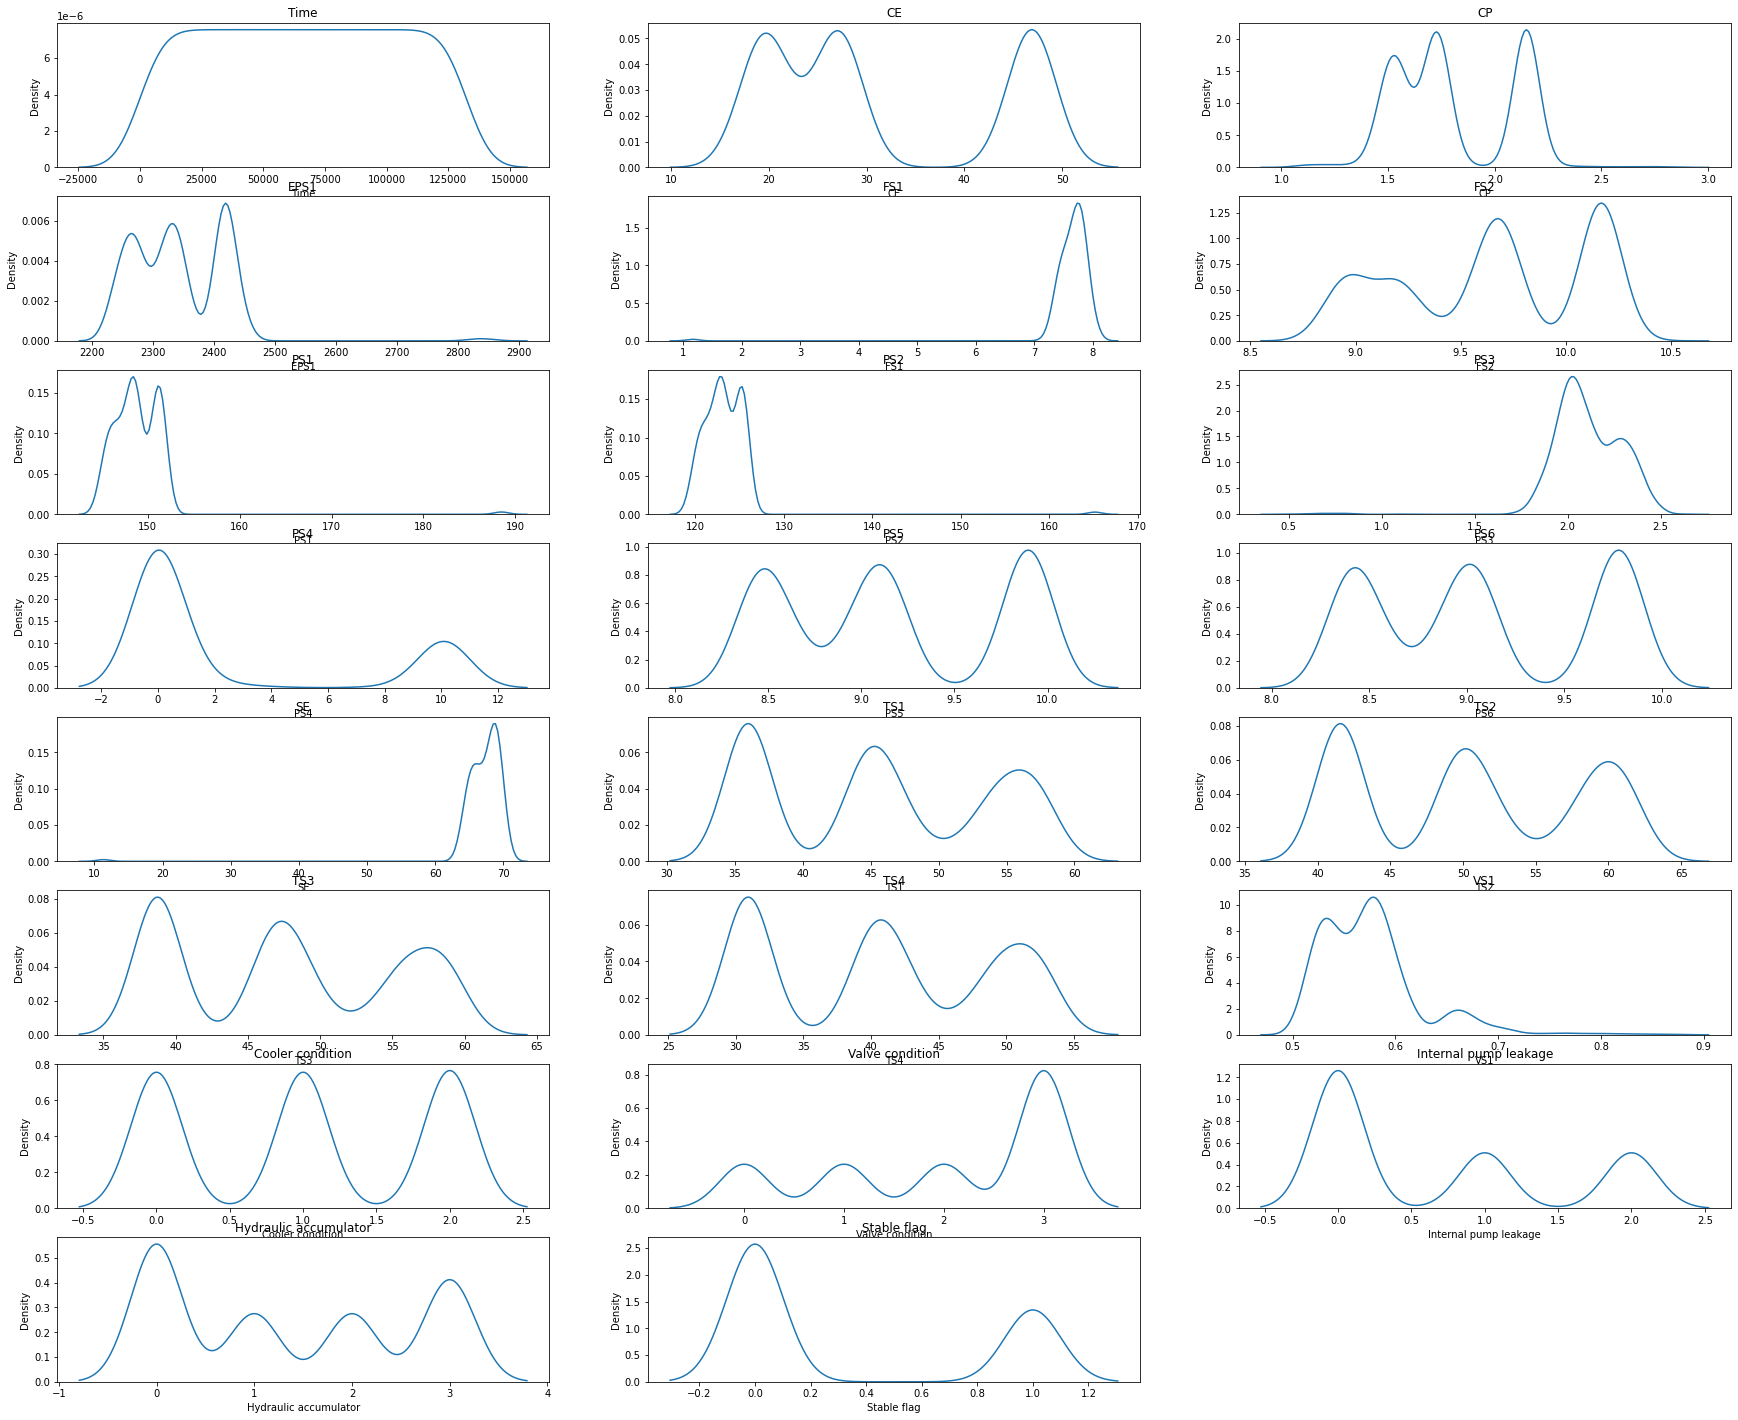

In [8]:
plt.figure(figsize=(30, 25))

i = 1
for column in df:
    data = df[column]
    plt.subplot(math.ceil(len(df.columns) / 3), 3, i)
    
    plt.title(column)
    sns.kdeplot(data)
    
    i += 1

plt.show()

<AxesSubplot:>

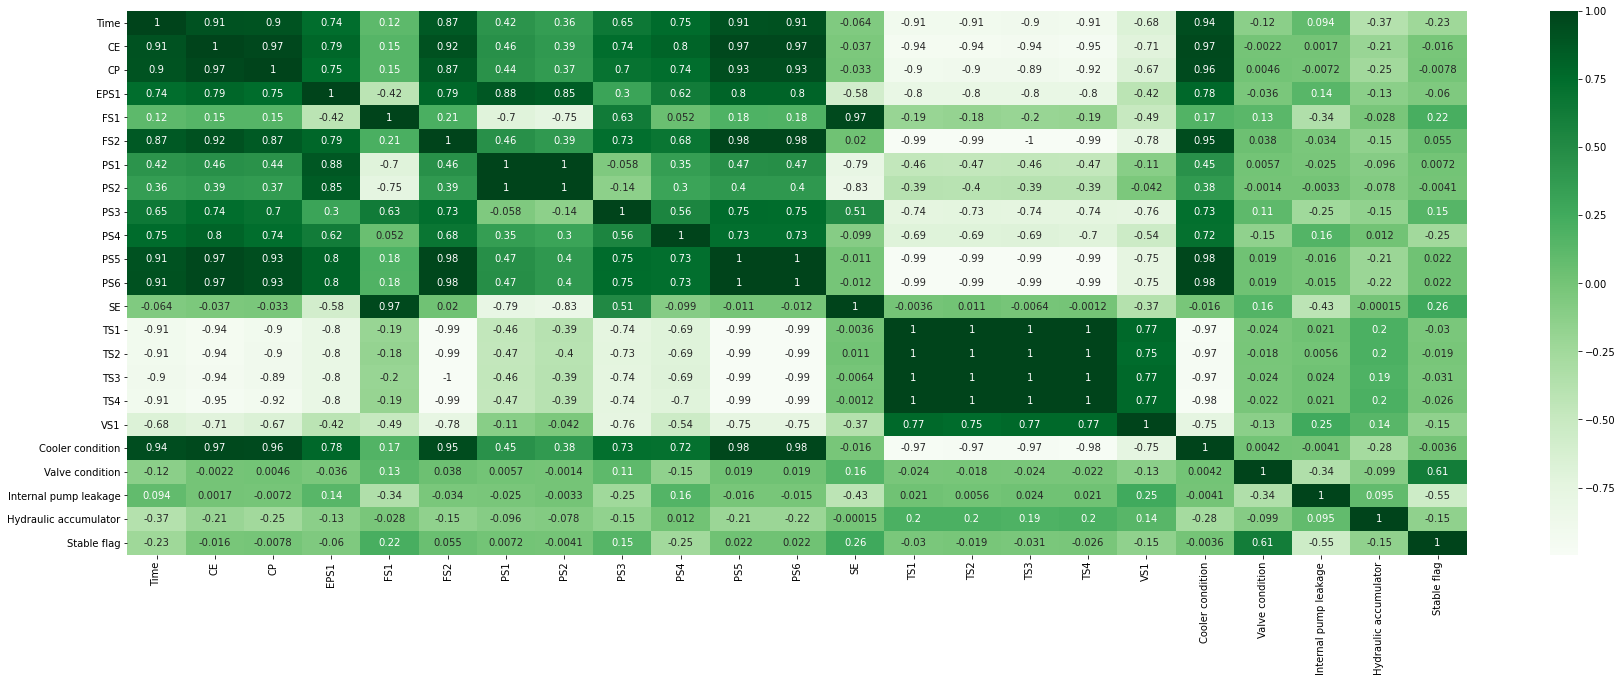

In [9]:
plt.figure(figsize=(30, 10))

corr = df.corr()
sns.heatmap(corr, cmap="Greens", annot=True)

## Making model
## Predicting LSTM
_Long Short Term Memory_

In [10]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_data = x_scaler.fit_transform(df[["Time", "CE", "EPS1", "FS2", "PS5", "TS1", "VS1"]])
y_data = y_scaler.fit_transform(df[["Cooler condition"]])

In [11]:
def prepare_data(x_data, y_data=None, history_window=1, shift=1):
    if not isinstance(x_data, np.ndarray) or not isinstance(y_data, np.ndarray):
        raise Exception("Data has to be a NumPy array.")
    
    num_batches = np.int(np.floor((len(x_data) - history_window) / shift)) + 1
    num_features = x_data.shape[1]

    x_output = np.repeat(np.nan, repeats=num_batches * history_window * num_features).reshape(num_batches, history_window, num_features)
    if y_data is None:
        for batch in range(num_batches):
            x_output[batch,:,:] = x_data[(0 + shift * batch):(0 + shift * batch + history_window),:]

        return x_output
    
    y_output = np.repeat(np.nan, repeats=num_batches)
    for batch in range(num_batches):
        x_output[batch,:,:] = x_data[(0 + shift * batch):(0 + shift * batch + history_window),:]
        y_output[batch] = y_data[(shift * batch + (history_window - 1))]

    return x_output, y_output

In [12]:
history_window = 30
shift = 1

x_data_processed, y_data_processed = prepare_data(x_data, y_data, history_window, shift)

In [13]:
x_train, x_validation, y_train, y_validation = train_test_split(
    x_data_processed, 
    y_data_processed,
    test_size=0.2,
    random_state=1
)

In [14]:
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation="tanh"),
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
    tf.keras.layers.LSTM(32, activation="tanh"),
    tf.keras.layers.Dense(96, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stopping]
)

Epoch 1/50
55/55 [==============================] - 4s 65ms/step - loss: 0.0268 - mean_absolute_error: 0.0853 - val_loss: 0.0036 - val_mean_absolute_error: 0.0315
Epoch 2/50
55/55 [==============================] - 2s 45ms/step - loss: 0.0019 - mean_absolute_error: 0.0248 - val_loss: 0.0019 - val_mean_absolute_error: 0.0178
Epoch 3/50
55/55 [==============================] - 2s 45ms/step - loss: 0.0015 - mean_absolute_error: 0.0196 - val_loss: 0.0030 - val_mean_absolute_error: 0.0310
Epoch 4/50
55/55 [==============================] - 2s 45ms/step - loss: 0.0014 - mean_absolute_error: 0.0202 - val_loss: 0.0037 - val_mean_absolute_error: 0.0323
Epoch 5/50
55/55 [==============================] - 2s 45ms/step - loss: 0.0013 - mean_absolute_error: 0.0178 - val_loss: 0.0017 - val_mean_absolute_error: 0.0171
Epoch 6/50
55/55 [==============================] - 2s 45ms/step - loss: 0.0010 - mean_absolute_error: 0.0164 - val_loss: 0.0023 - val_mean_absolute_error: 0.0181
Epoch 7/50
55/55 [====

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           69632     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 96)                3168      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 147,169
Trainable params: 147,169
Non-trainable params: 0
__________________________________________________

In [17]:
# Test prediction made with categorical model.
predictions = model.predict(x_validation)

predictions_transformed = label_encoder_cooler_condition.inverse_transform(np.round(y_scaler.inverse_transform(predictions)).astype(int).ravel())
y_validation_transformed = label_encoder_cooler_condition.inverse_transform(y_scaler.inverse_transform(y_validation.reshape(-1, 1)).astype(int).ravel())

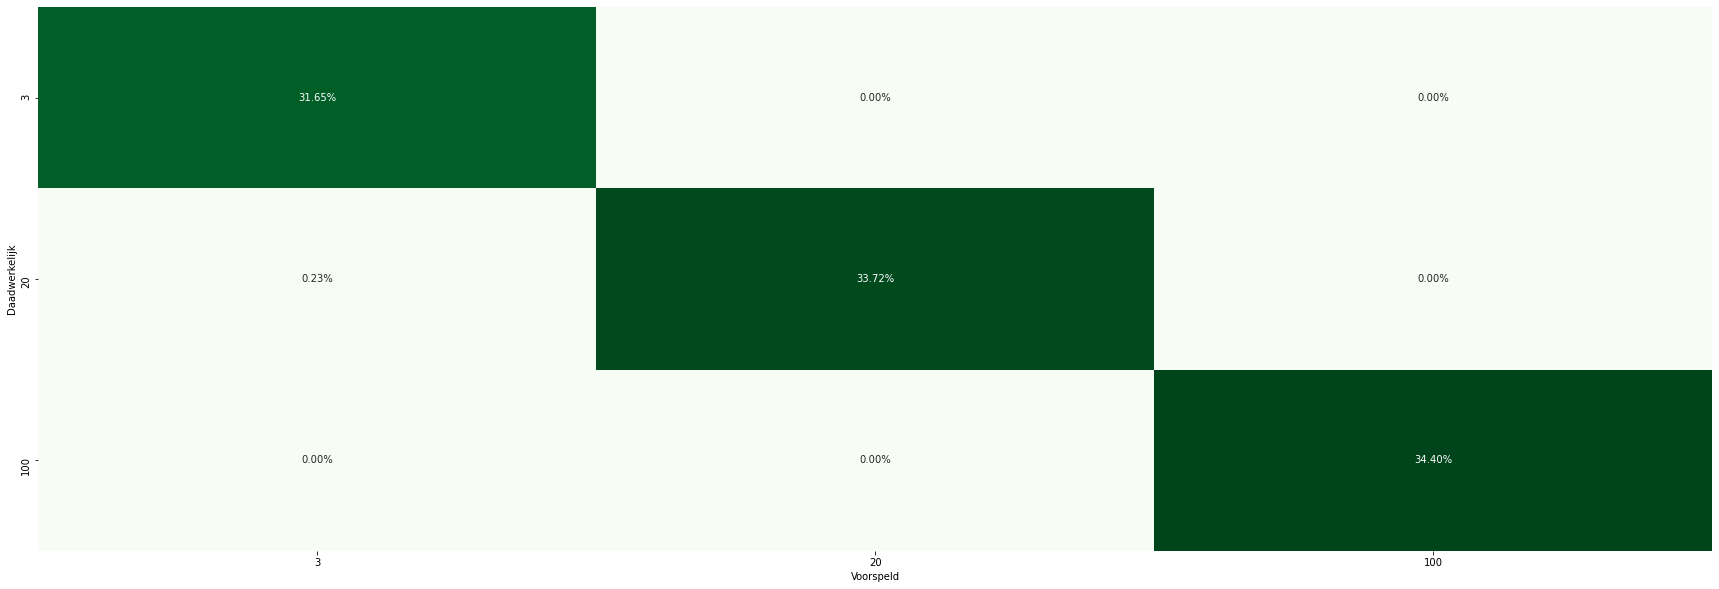

In [18]:
plt.figure(figsize=(30, 10))

categories = ['3', '20', '100']

cf_matrix = metrics.confusion_matrix(y_validation_transformed, predictions_transformed)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,cmap="Greens", fmt=".2%", cbar=False)

plt.xlabel("Voorspeld")
plt.ylabel("Daadwerkelijk")

plt.show()

In [19]:
def timeseries_evaluation_metrics_func(y_true, y_pred, x_true):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}')
    print(f'Adjusted R2 is: {1-(1-metrics.r2_score(y_true, y_pred))*((len(x_true)-1)/(len(x_true)-len(x_true[0])-1))}',end='\n\n') 
    
print("Evaluating metrics")
timeseries_evaluation_metrics_func(y_validation_transformed, predictions_transformed, x_validation)

Evaluating metrics
Evaluation metric results:-
MSE is : 0.6628440366972477
MAE is : 0.0389908256880734
RMSE is : 0.8141523424379786
MAPE is : 0.19495412844036697
R2 is : 0.99963237220155
Adjusted R2 is: 0.9996051405127759

